### Analysis of Nanopore long reads

During sequencing, the reads have already been filtered for quality, i.e. only reads with a Q-score >= 8 are kept. 
Also, alignment was performed by the Minion software after sequencing and basecalling. 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pysam
from functions_ import *
from plotting import *
from utils import *
import csv
from Nanopore_functions import *
from Bio import SeqIO
from matplotlib import patches
import gzip 
from matplotlib.colors import LinearSegmentedColormap
import ast 

ref_WT = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaatgtccgcggaagcgcagaacgatccgctgctgccgggctatagctttaacgcgcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgcgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccgctatagcgaactgctggcgattaacctgctggaacagctgctgctgcgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccgagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccgcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper()

ref_R5 = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaAtgtccgAggaagcgcagaacgatccgctgctgccgggctatagctttaacgcgcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgcgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccgctatagcgaactgctggcgattaacctgAtAgaacagctgctgctgcgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccgagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccAcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper() ## R5

ref_R2 = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaAtgtccgcgAaagcgcagaacgatccgctgctgccgggctatagctttaacgcAcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgAgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccTctatagcgaactgctgAcAattaacctgctggaacagctgctgctgcgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccTagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccTcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper() ## R2

annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294'] #'*294'

annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']#'*294'

In [4]:
barcode = "barcode09"
quality = 20

with open(f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
    reader = csv.reader(f)
    all_reads = list(reader)  # Convert the reader object into a list

all_reads = [read[0] for read in all_reads]
# Print the data
print(len(all_reads))

indels = pd.read_csv(f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0)
start_arac =297-9
end_arac = indels.shape[1]-355+3
indels = indels/len(all_reads)

data_type = "AA"
ref = ref_R5 if barcode in ["barcode06", "barcode07", "barcode08", "barcode09"] else ref_R2
annots = annots_R5 if barcode in ["barcode06", "barcode07", "barcode08", "barcode09"] else annots_R2

all_variants, enrichment_counts,enrichment_relative, indels_freq = characterize_DMS_Nanopore(aligned_reads = all_reads, ref = ref[9:], data_type = data_type)


# araclov2_enr = enrichment_relative.iloc[:,(297-9)//3:-355//3]
# araclov2_enr.columns = annots_R5

enrichment_counts.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv")
enrichment_relative.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv")
all_variants.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv")

if data_type == "AA": 
    araclov2_enr = enrichment_relative.iloc[:,(297-9)//3:(-355+3)//3]
    araclov2_enr.columns = annots
    araclov2_enr.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv")

95665
83828 sequences have off target indels
95665 sequences are included in the enrichment analysis


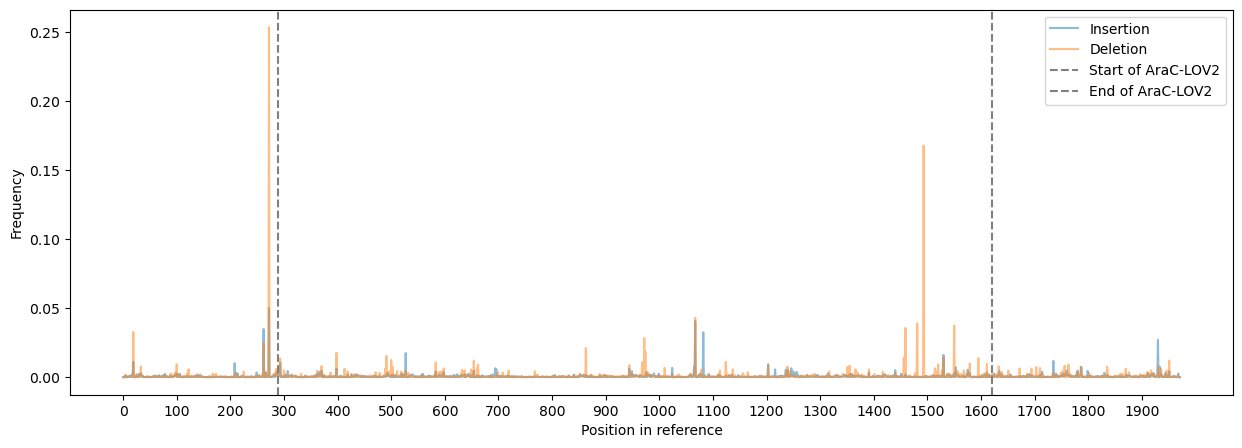

In [5]:
fig, axes = plt.subplots(figsize=(15, 5))
plt.plot(indels.loc["I"], label = "Insertion", alpha = 0.5)
plt.plot(indels.loc["D"], label = "Deletion", alpha = 0.5)
plt.axvline(start_arac, color = "grey", linestyle = "--", label = "Start of AraC-LOV2")
plt.axvline(end_arac, color = "grey", linestyle = "--", label = "End of AraC-LOV2")
plt.xticks(list(range(0, len(indels.columns), 100)), list(range(0, len(indels.columns), 100)))
plt.xlabel("Position in reference")
plt.ylabel("Frequency")
plt.legend()
plt.show()

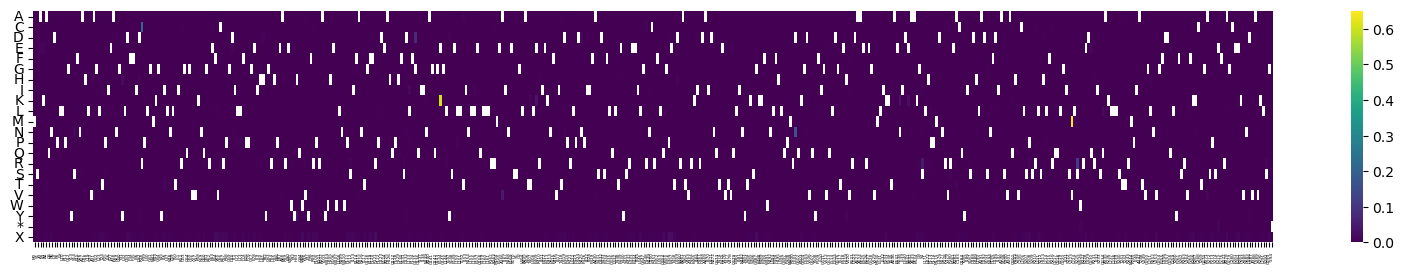

In [71]:
fig, axes = plt.subplots(figsize = (20, 3))
sns.heatmap(araclov2_enr, cmap = "viridis", xticklabels = annots_R2, yticklabels=True)
axes.set_xticklabels(axes.get_xticklabels(),fontsize = 3)
plt.show()

In [ ]:
### the code was taken and adapted from https://dmnfarrell.github.io/python/fastq-quality-python ####

filename = f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/filtered_fastq/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.fastq.gz"

fastq_parser = SeqIO.parse(gzip.open(filename,"rt"), "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
############ correct for coverage
df = df.fillna(0)

In [ ]:
n_cut = 9
fig, axes = plt.subplots(3,1, figsize=(15, 5))
axes[0].plot(indels.loc["I"], label = "Insertion", alpha = 0.5)
axes[0].plot(indels.loc["D"], label = "Deletion", alpha = 0.5)
axes[0].set_xlim(n_cut, len(enrichment_relative.columns))
axes[0].set_xticks(list(range(n_cut, len(enrichment_relative.columns), 100)))
axes[0].set_xticklabels([])
axes[0].axvline(start_arac, color = "grey", linestyle = "--", label = "Start of AraC-LOV2")
axes[0].axvline(end_arac, color = "grey", linestyle = "--", label = "End of AraC-LOV2")
axes[0].legend(fontsize = 8, frameon = False)
axes[0].set_ylabel("Frequency")

rect = patches.Rectangle((0,0),len(df.iloc[:,:indels.shape[1]].columns),20,linewidth=0,facecolor='r',alpha=.4)
axes[1].add_patch(rect)
rect = patches.Rectangle((0,20),len(df.iloc[:,:indels.shape[1]].columns),8,linewidth=0,facecolor='yellow',alpha=.4)
axes[1].add_patch(rect)
rect = patches.Rectangle((0,28),len(df.iloc[:,:indels.shape[1]].columns),12,linewidth=0,facecolor='g',alpha=.4)
axes[1].add_patch(rect)
df.iloc[:,:indels.shape[1]].mean().plot(ax=axes[1],c='black')
boxprops = dict(linestyle='-', linewidth=0.1, color='black')
df.iloc[:,:indels.shape[1]].plot(kind='box', ax=axes[1], grid=False, showfliers=False, 
        color=dict(boxes='black',whiskers='black'), boxprops=boxprops,     whiskerprops={'linewidth': 0.1} ) # Adjust linewidth as needed)
axes[1].set_xlim(n_cut, len(enrichment_relative.columns))
axes[1].set_xticks(list(range(n_cut, len(enrichment_relative.columns), 100)))
axes[1].set_xticklabels([])
axes[1].set_ylabel("Quality")



sns.heatmap(pd.DataFrame(enrichment_relative.iloc[:-1,:].sum()).T,  ax = axes[2], cbar = False, cmap = "viridis", yticklabels=False)
axes[2].set_xticks(list(range(0, len(enrichment_relative.columns), 100)))
axes[2].set_xticklabels(list(range(0, len(enrichment_relative.columns), 100)))
axes[2].set_ylabel("Enrichment")

fig.suptitle(f"{barcode} - Quality {quality}")
fig.supxlabel("Position in reference")
#plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/enrichment_heatmap_combined.pdf", bbox_inches = "tight")
plt.show()

In [ ]:
all_variants = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
if data_type == "AA": 
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)

In [ ]:
coverage_plot(all_variants.sum())

In [ ]:
plot_df = araclov2_enr.copy()
plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

fig, axes = plt.subplots(figsize = (40,2))
sns.heatmap(plot_df, xticklabels=annots, ax = axes, cmap = "viridis")
plt.xticks(fontsize = 5)
plt.title(f"{barcode} with Q={quality} filter")
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_heatmap_combined.pdf", bbox_inches = "tight")
plt.show()

In [ ]:
### the code was taken and adapted from https://dmnfarrell.github.io/python/fastq-quality-python ####
from Bio import SeqIO
from matplotlib import patches
import gzip 
bc = "barcode01"
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
filename = f"/home/student/anna/DMS_analysis/data/Nanopore/{bc}/filtered_Q{quality}_maxminlen/filtered_fastq/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.fastq.gz"

fastq_parser = SeqIO.parse(gzip.open(filename,"rt"), "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
############ correct for coverage
df = df.fillna(0)
###### 


l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,1900))
ax.set_ylim((0,40))
ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/read_quality_per_pos.pdf", bbox_inches='tight')
plt.show()


In [ ]:
plot_df = araclov2_enr.copy()

fig, axes = plt.subplots(figsize = (40,4))
sns.heatmap(plot_df, xticklabels=annots_R5, yticklabels=plot_df.index, ax = axes, cmap = "viridis")
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 10, rotation = 0)
plt.title(f"{barcode} with Q={quality} filter")

#plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/enrichment_heatmap_combined.pdf", bbox_inches = "tight")
plt.show()

In [ ]:
all_counts = {}
data_type = "AA"
quality = 15

for bc_nr in range(1,10): 
    barcode = f"barcode0{bc_nr}"
    counts = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
    all_counts[barcode] = counts


In [ ]:
for enrichment in enrichments.values():
    coverage_plot(enrichment.sum())

In [2]:
enrichments = {}
data_type = "AA"
quality = 20

for bc_nr in range(1,10): 
    barcode = f"barcode0{bc_nr}"
    enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    enrichments[barcode] = enrichment_relative


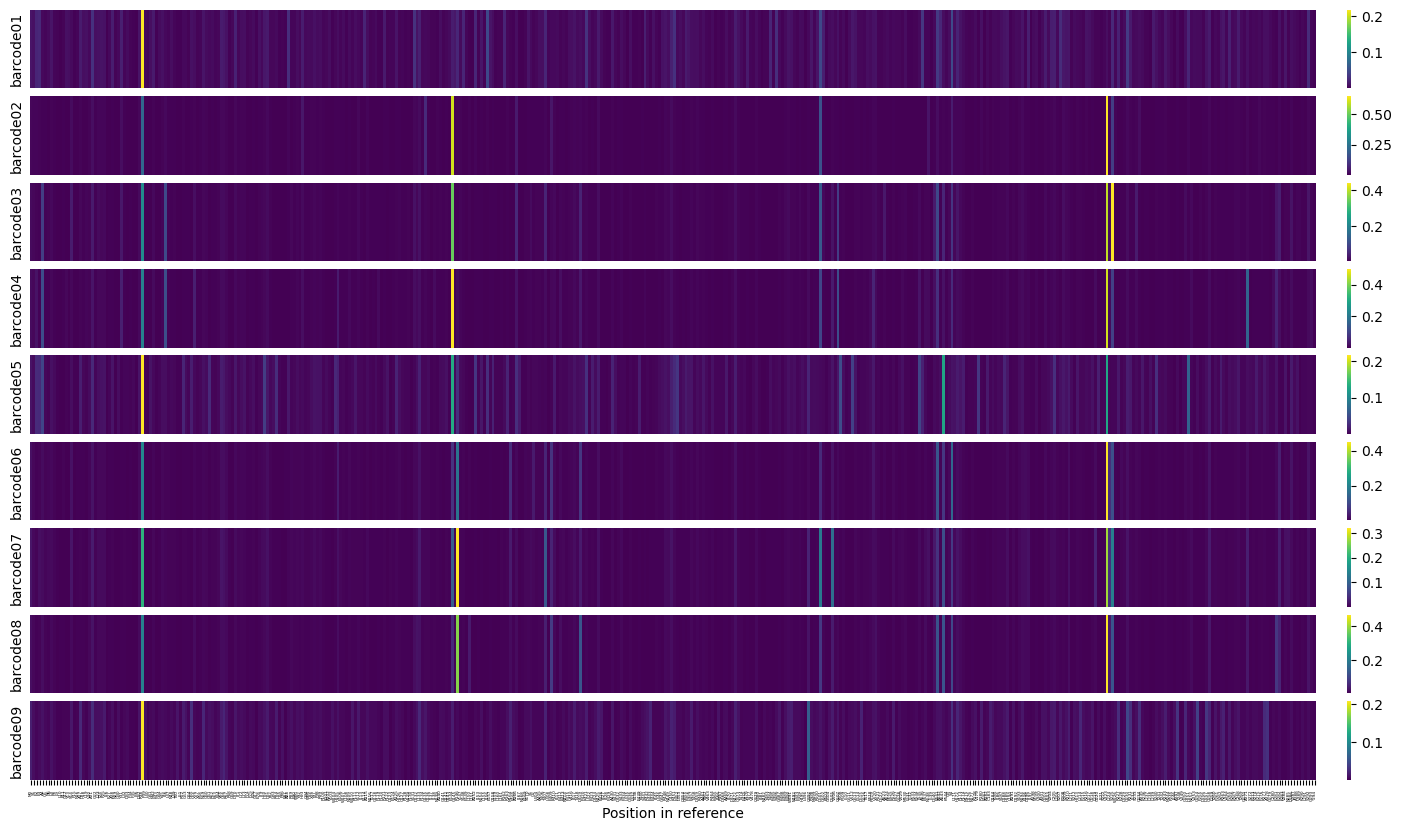

In [89]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')
    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, vmax=None, cbar = True, yticklabels=False, cbar_kws={"pad" : 0.02} )
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

# ## add at the bottom of the figure horizontally a cbar for the relative counts
# cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
# cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
# cbar.set_label("mutation rate", fontsize = 15)
# cbar.ax.tick_params(labelsize=10)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_bcall_enrichment_heatmap_all_barcodes_Q{quality}_diffCmap.pdf", bbox_inches = "tight")

In [3]:
total_enrichment = pd.DataFrame(columns=annots_R5, index = ["barcode06", "barcode07", "barcode08"]) # ["barcode01", "barcode02", "barcode03", "barcode04"]

threshold = 0.05

for barcode in total_enrichment.index: 

    enr = enrichments[barcode].copy()
    sum_enr = pd.DataFrame(enr.iloc[:-1,:].sum()).T

    total_enrichment.loc[barcode] = sum_enr.values[0]

total_enrichment = total_enrichment.iloc[:,:-1]


In [4]:
## set all values above the threshold to 1
total_enrichment[total_enrichment > threshold] = 1
## set all values below the threshold to 0
total_enrichment[total_enrichment <= threshold] = 0

In [5]:
total_enrichment.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/pymol/total_enrichment_R5_Bcs_Q{quality}_treshold5e-2.csv", header=True, index=False)

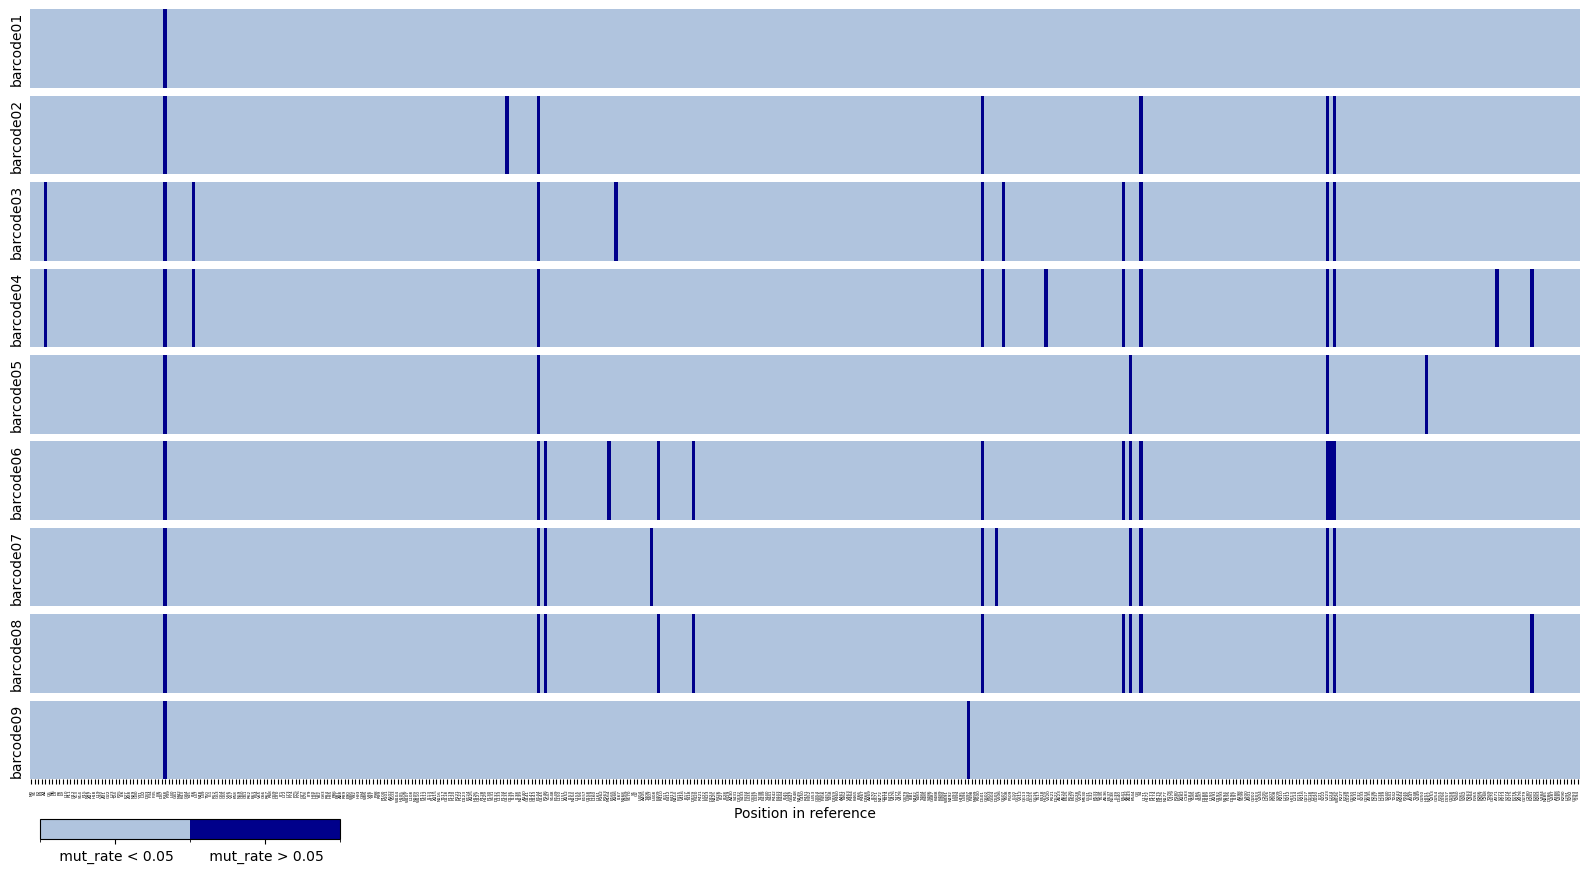

In [8]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)
threshold = 0.05

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')

    colors = ["lightsteelblue", "#00008b"]
    my_cmap = mcolors.ListedColormap(colors)
    # Create a normalization based on threshold
    norm = mcolors.BoundaryNorm([0, threshold, 1], my_cmap.N)

    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, cbar = False, yticklabels=False, norm = norm )
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
# cbar.set_label("mutation rate", fontsize = 15)
# cbar.ax.tick_params(labelsize=10)
## cbar = ax.collections[0].colorbar
cbar.set_ticks([threshold / 2, (threshold + 1) / 2])  # Places ticks at middle of each color range
cbar.set_ticklabels([f" mut_rate < {threshold}", f" mut_rate > {threshold}"])  # Custom labels

plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_basecalling_enrichment_heatmap_all_barcodes_Q{quality}_binary.pdf", bbox_inches = "tight")

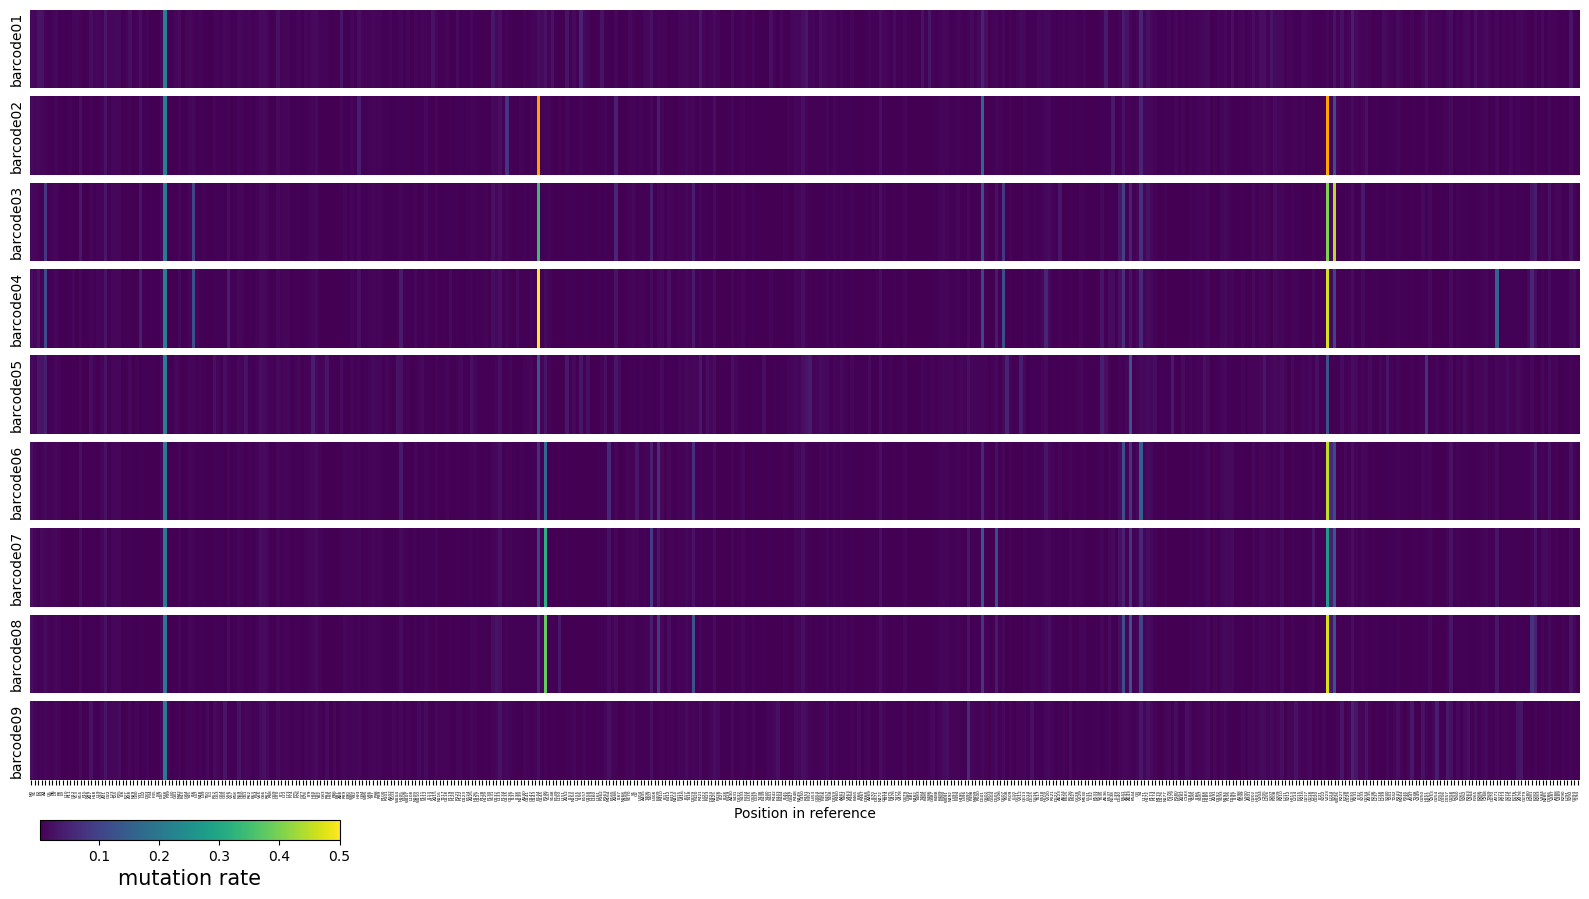

In [91]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')
    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, vmax=0.5, cbar = False, yticklabels=False)
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate", fontsize = 15)
cbar.ax.tick_params(labelsize=10)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_basecallingenrichment_heatmap_all_barcodes_Q{quality}.pdf", bbox_inches = "tight")

In [ ]:
plot_mutation_enrichment(variants_df=enrichment_relative, ref_seq=ref[9:] if data_type != "AA" else translate_dna2aa(ref[9:]), data_type=data_type)

In [85]:
with open(f"/home/student/anna/DMS_analysis/data/Nanopore/barcode02/highly_accurate_basecalling/filtered_Q20_maxminlen/processed_reads/cleaned_reads_base_qualitities.csv", "r", newline="") as f:
    reader = csv.reader(f)
    all_quals = [[int(value) if value.isdigit() else np.nan for value in row] for row in reader]

ref = ref_R2
AraC_start_R2_seq = "AtgtccgcgAaag".upper()
AraC_end_seq = "TGAGCGGGTAA"


AraC_start = ref.find(AraC_start_R2_seq)-9 
AraC_end = ref.find(AraC_end_seq)+ len(AraC_end_seq) -9 
df = pd.DataFrame(all_quals)
df = df.iloc[:,AraC_start:AraC_end]
df.columns = list(range(len(df.columns)))

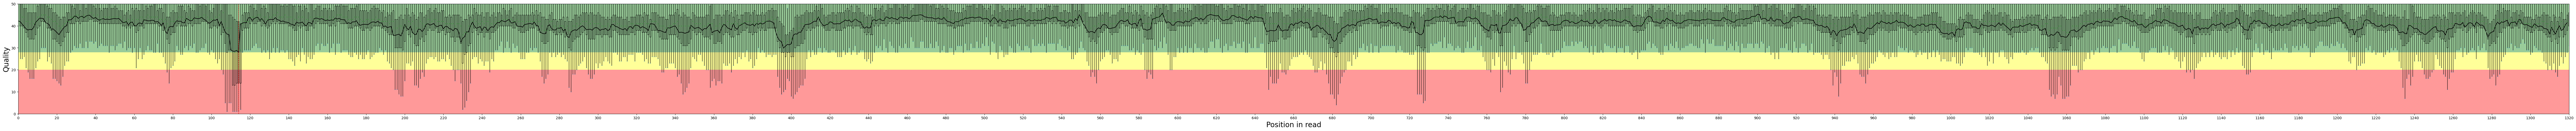

In [75]:
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,30,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,len(df.columns)))
ax.set_ylim((0,50))
#ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
ax.axvline(38*3, color = "red", linestyle = "--", label = "Start of AraC-LOV2", linewidth = 1)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/base_quality_per_pos_AraCLOV2.pdf", bbox_inches='tight')
plt.show()

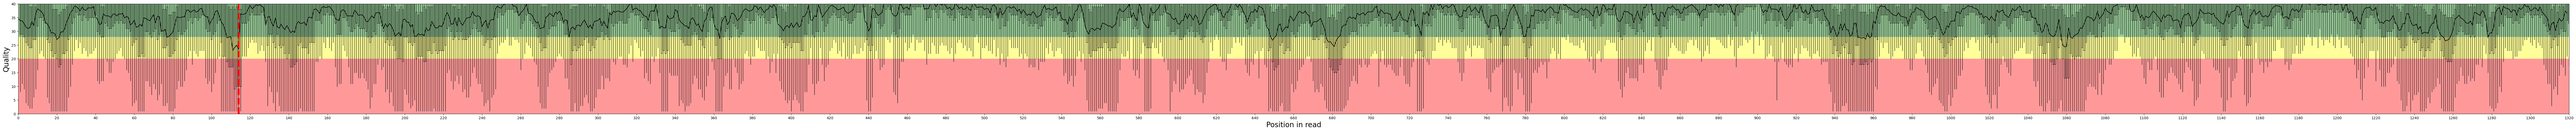

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)

df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,len(df.columns)))
ax.set_ylim((0,40))
#ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
ax.axvline(38*3, color = "red", linestyle = "--", label = "Start of AraC-LOV2", linewidth = 5)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/base_quality_per_pos_AraCLOV2.pdf", bbox_inches='tight')
plt.show()

## Cooccurrence?

In [25]:

annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294'] #'*294'

annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']#'*294'

annots_WT = ['M0', 'S1', 'A2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'R251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']#'*294'

In [66]:
barcode = "barcode03"
quality = 20
ref = ref_R2 if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else ref_R5 #ref_WT
annots = annots_R2 if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else annots_R5 # annots_WT 

with open(f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
    reader = csv.reader(f)
    all_reads = list(reader)  # Convert the reader object into a list

all_reads = [read[0] for read in all_reads]
# Print the data
print(len(all_reads))

indels = pd.read_csv(f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0)

AraC_start_R5_seq = "ATGTCCGAGGAAGC"
AraC_WT_start = "atgtccgcgga".upper()
AraC_start_R2_seq = "AtgtccgcgAaag".upper()
AraC_end_seq = "TGAGCGGGTAA"


AraC_start = ref.find(AraC_start_R5_seq)-9 if ref == ref_R5 else ref.find(AraC_start_R2_seq)-9 # 9 nts were cut from the start
AraC_start = ref.find(AraC_WT_start)-9 if ref == ref_WT else AraC_start
AraC_end = ref.find(AraC_end_seq)+ len(AraC_end_seq) -9 

reads_roi = [read[AraC_start:AraC_end] for read in all_reads]
ref_roi = ref[AraC_start+9:AraC_end+9]
all_aas = [translate_dna2aa(read) for read in reads_roi]
ref_aa = translate_dna2aa(ref_roi) 


161585


In [67]:
ref_aa

'MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*'

In [68]:
print(ref_aa)
print("\n")

for i in all_aas[:20]: 
    print(i)

MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRQDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAVKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLRWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLRG*
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGIKGYXLNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFA

In [69]:
def get_genotype_dict_from_AAseqs(all_Aas, ref_AAseq, ref_aa_annot, not_masked_positions = None, combined = False): 
    """
    Function to get the genotype dictionary from the AA sequences of the reads
    all_Aas: list of AA sequences of the reads
    ref_AAseq: reference AA sequence
    ref_aa_annot: list of the reference AA annotations
    not_masked_positions: list of positions that should be considered

    returns: 
    genotypes: dictionary with the genotypes and their counts
    """
    genotypes = {}

    for read in all_Aas:
        variant = []
        for idx, Aa in enumerate(read): 
            if not_masked_positions and idx not in not_masked_positions: ## if the position is masked, skip
                continue
            else:
                if Aa != "X" and Aa != ref_AAseq[idx]: 
                    observed_mut = f"{ref_aa_annot[idx]}{Aa}" if combined else ref_aa_annot[idx]
                    variant.append(observed_mut)
            
        if len(variant) == 0: 
            variant = "WT"
        else: 
            variant = "_".join(variant)

        genotypes[variant] = genotypes.get(variant, 0) + 1
        
    return genotypes
        

In [ ]:
#get idx of these observed anntos in annots
observed_muts_WT_names = ['A2', 'E3', 'R89', 'H93', 'F98', 'S131', 'E144', 'R146', 'L150', 'A152', 'L156', 'M164', 'A166', 'T407', 'E409', 'D419', 'R421', 'S441', 'Q497', 'D501', 'D505', 'H519', 'A523', 'T535', 'N537', 'D540', 'E541', 'A543', 'S4', 'D196', 'V223', 'S225', 'R251', 'R263', 'A278', 'E281', 'S292'] ## E537 statt N537??

observed_muts_R2_names = ['A2', 'K3', 'R89', 'H93', 'F98', 'S131', 'E144', 'L146', 'L150', 'T152', 'L156', 'M164', 'A166', 'T407', 'E409', 'D419', 'R421', 'S441', 'Q497', 'D501', 'D505', 'H519', 'A523', 'T535', 'E537', 'D540', 'E541', 'A543', 'S4', 'D196', 'V223', 'S225', 'L251', 'R263', 'A278', 'E281', 'S292']

observed_muts_R5_names = ['E2', 'E3', 'R89', 'H93', 'F98', 'S131', 'E144', 'R146', 'L150', 'A152', 'I156', 'M164', 'A166', 'T407', 'E409', 'D419', 'R421', 'S441', 'Q497', 'D501', 'D505', 'H519', 'A523', 'T535', 'E537', 'D540', 'E541', 'A543', 'S4', 'D196', 'V223', 'S225', 'H251', 'R263', 'A278', 'E281', 'S292']

muts_prior = ["E3", "R146", "A152", "R251"]

observed_muts_idx = [annots.index(i) for i in muts_prior]#[annots.index(i) for i in observed_muts_R2_names]

In [70]:
araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
total_enrichment = araclov2_enr.iloc[:-1,:].sum()

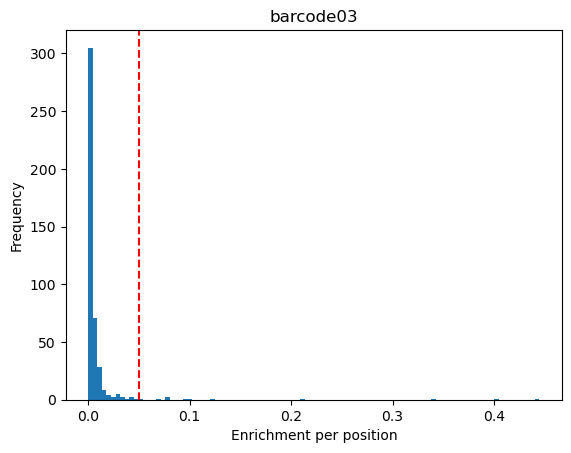

In [71]:
plt.hist(total_enrichment, bins = 100)
#plt.xlim(0, 0.1)
plt.axvline(0.05, color = "red", linestyle = "--")

plt.xlabel("Enrichment per position")
plt.ylabel("Frequency")
plt.title(barcode)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/total_enrichment_hist.pdf", bbox_inches = "tight")
plt.show()

In [72]:
#pos = set([idx for idx, mut_rate in enumerate(total_enrichment) if mut_rate > 0.1] + observed_muts_idx)
pos =[idx for idx, mut_rate in enumerate(total_enrichment)if mut_rate > 0.05] #+ observed_muts_idx
pos = list(sorted(set(pos)))
print(len(pos), "positions are included in variant calling")
genotypes = get_genotype_dict_from_AAseqs(all_aas, ref_aa, annots, combined=True, not_masked_positions=pos)


## sort genotypes after size 
genotypes_sorted = dict(sorted(genotypes.items(), key=lambda item: item[1], reverse=True))
sum_genotypes = sum(genotypes_sorted.values())
genotypes_sorted = {k: v/sum_genotypes*100 for k, v in genotypes_sorted.items()}
print("before filtering for percentage",  len(genotypes_sorted), "variants")
## filter for variants with >0.5 percent 
genotypes_sorted = {k: v for k, v in genotypes_sorted.items() if v > 0.5}
print("after filtering for percentage",len( genotypes_sorted), "variants")
print(sum(genotypes_sorted.values()), "percent of all reads can be explained by the filtered genotypes")

11 positions are included in variant calling
before filtering for percentage 3386 variants
after filtering for percentage 32 variants
73.33353962310858 percent of all reads can be explained by the filtered genotypes


In [73]:
genotypes_table = pd.DataFrame(columns = ["count"] + annots, index = list(genotypes_sorted.keys()), data = 0, dtype = "float")

for variant, count in genotypes_sorted.items(): 
    genotypes_table.loc[variant, "count"] =count
    if variant != "WT":  
        for mut in variant.split("_"): 
            genotypes_table.loc[variant, mut[:-1]] = 1.0

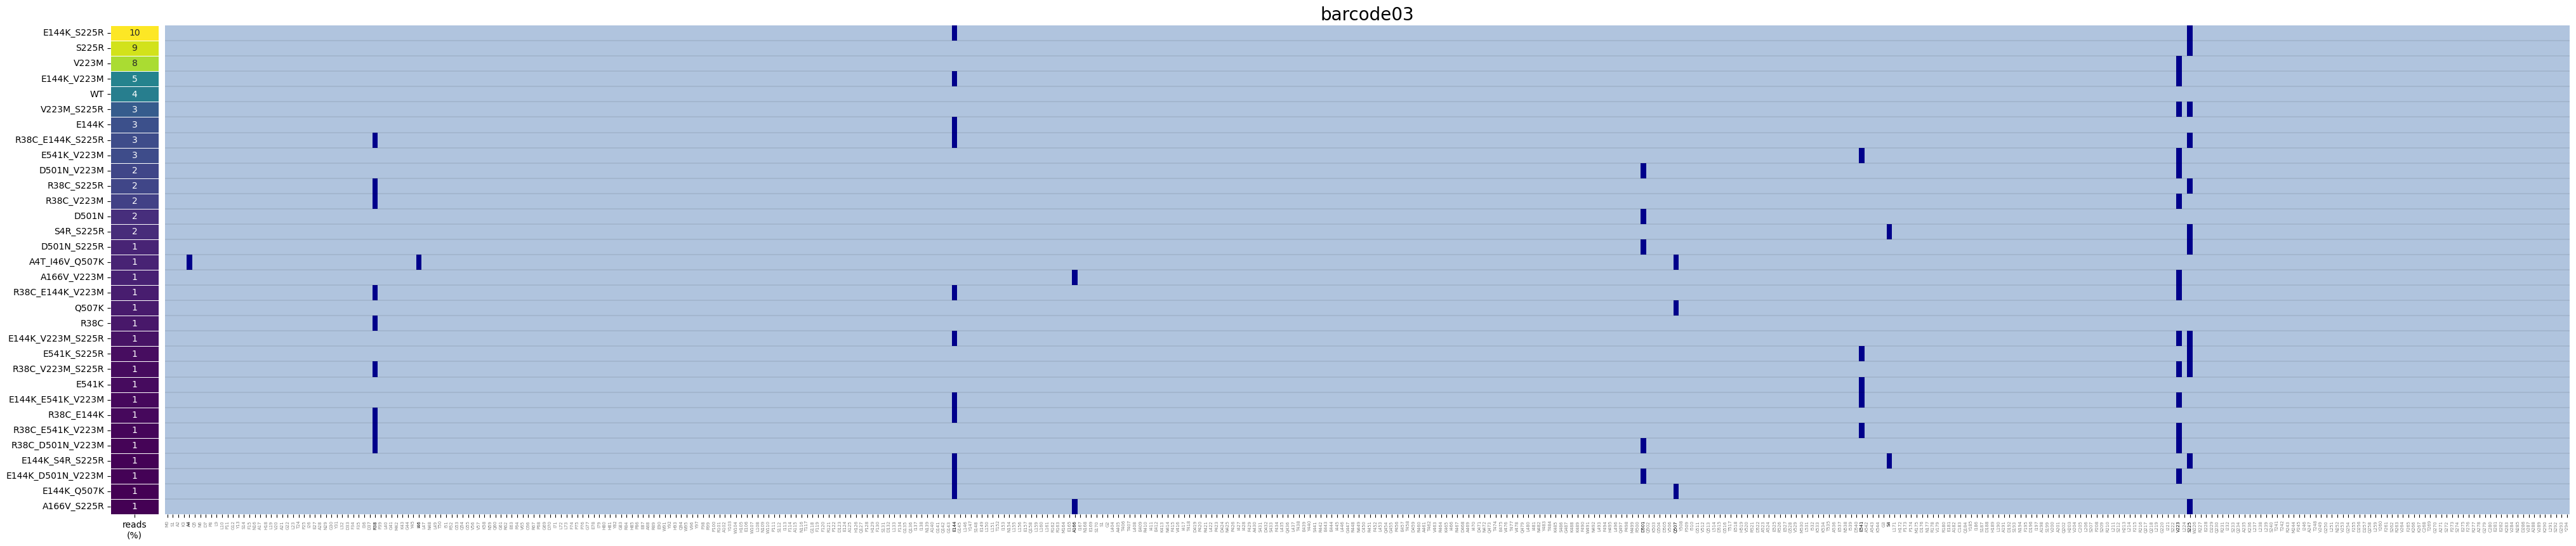

In [74]:
fig, ax = plt.subplots(1,2, figsize=(50, 10), gridspec_kw={"width_ratios": [0.1, 5]})
fig.subplots_adjust(wspace=0.005)

## choose binary colormap
binary_cmap = LinearSegmentedColormap.from_list("binary_blue", ["lightsteelblue", "#00008b"])

sns.heatmap(genotypes_table.iloc[:, :1], ax=ax[0], cmap="viridis", cbar=False, annot=True, fmt=".0f",
            linewidths=0.5, linecolor="white", cbar_kws={"label": "Occurrences"}, yticklabels=True, xticklabels=["reads\n(%)"])


ax[1] = sns.heatmap(genotypes_table.iloc[:,1:], cbar_kws={"label": "mutation rate"}, cmap = binary_cmap, xticklabels=True, cbar = False, yticklabels=False )
plt.xticks(fontsize = 5)
for y in range(1, genotypes_table.shape[0]):  # Iterate over columns
    ax[1].axhline(y, color="black", lw=0.1)  # Add vertical lines

### show all annots not included in observed_muts in grey in the xticks
for i, annot in enumerate(annots): 
    if i not in pos: 
        ax[1].get_xticklabels()[i].set_color("grey")

plt.title(f"{barcode}", fontsize = 20)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_heatmap_pos8perc_filt0_5perc.pdf", bbox_inches = "tight")
plt.show()

In [75]:
## filter genotypes_table for columns in pos 
genotypes_table_filt = genotypes_table.iloc[:, 1:]
genotypes_table_filt = genotypes_table_filt.iloc[:, pos]
genotypes_table_filt= pd.concat(( genotypes_table["count"], genotypes_table_filt), axis = 1)


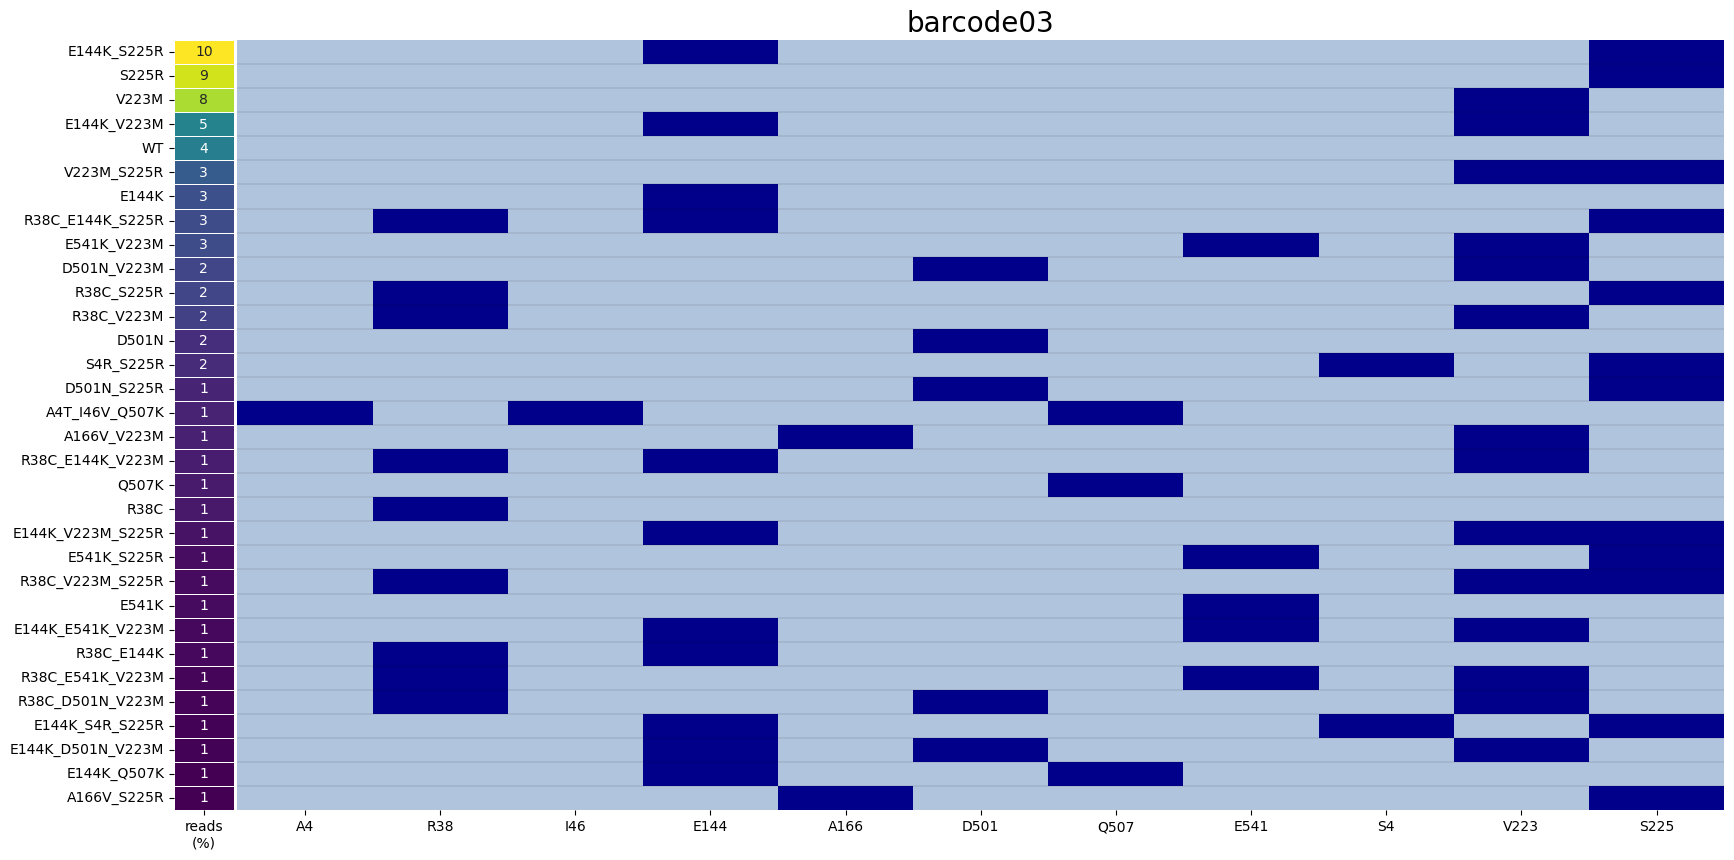

In [76]:
fig, ax = plt.subplots(1,2, figsize=(20, 10), gridspec_kw={"width_ratios": [0.2, 5]})
fig.subplots_adjust(wspace=0.005)
## choose binary colormap

sns.heatmap(genotypes_table_filt.iloc[:, :1], ax=ax[0], cmap="viridis", cbar=False, annot=True, fmt=".0f",
            linewidths=0.5, linecolor="white", cbar_kws={"label": "Occurrences"}, yticklabels=True, xticklabels=["reads\n(%)"])


ax[1] = sns.heatmap(genotypes_table_filt.iloc[:,1:], cbar_kws={"label": "mutation rate"}, cmap = binary_cmap, xticklabels=True, cbar = False, yticklabels=False )
plt.xticks(fontsize = 10)
for y in range(1, genotypes_table_filt.shape[0]):  # Iterate over columns
    ax[1].axhline(y, color="black", lw=0.1)  # Add vertical lines

plt.title(f"{barcode}", fontsize = 20)

plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_heatmap_pos8perc_filt0_5perc_filt_WT.pdf", bbox_inches = "tight")
plt.show()

<Axes: >

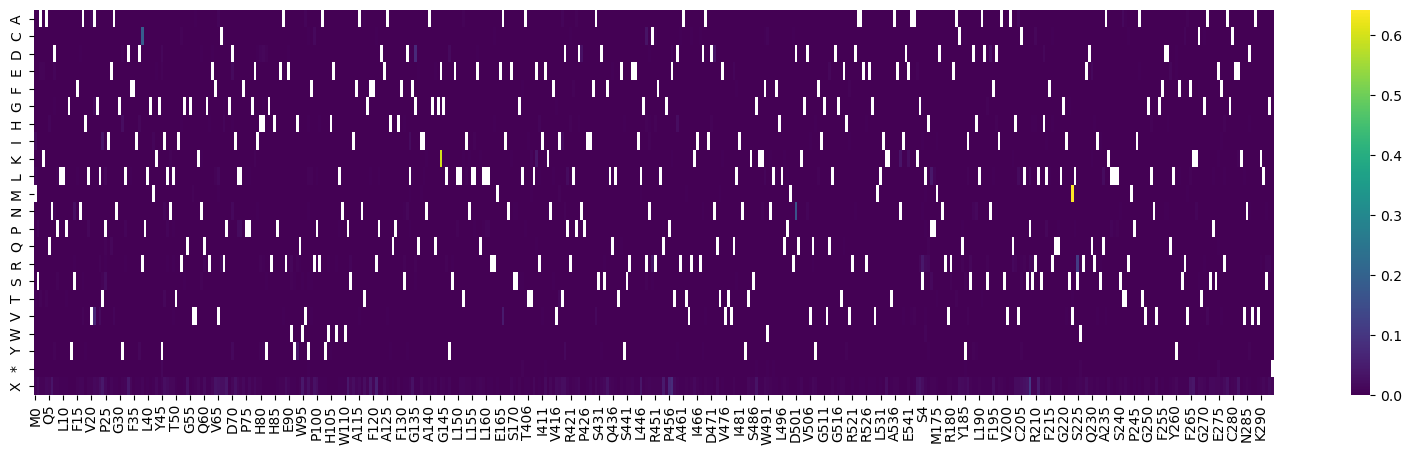

In [493]:
plt.figure(figsize=(20, 5))
sns.heatmap(araclov2_enr, cmap = "viridis")

In [428]:
idxs_38 = [idx for idx, aa in enumerate(all_aas) if aa[38] != "R" and aa[38] != "X"]

In [456]:
C38mut = [read for idx, read in enumerate(all_reads) if idx in idxs_38]


In [462]:
variants38 = {}
for x in C38mut: 
    variants38[x[AraC_start+38*3:AraC_start+38*3+3]] = variants38.get(x[AraC_start+38*3:AraC_start+38*3+3], 0) + 1


In [463]:
variants38

{'GGC': 453,
 'AGC': 369,
 'CAC': 417,
 'TGC': 40154,
 'AAG': 25,
 'GAC': 22,
 'TTC': 15,
 'CTC': 18,
 'CCC': 42,
 'TAA': 4,
 'CTG': 11,
 'TAG': 11,
 'CCT': 14,
 'AAC': 17,
 'GTG': 1,
 'GGG': 2,
 'TGG': 7,
 'CCA': 8,
 'TCC': 2,
 'TAC': 6,
 'AGT': 7,
 'TGT': 21,
 'CCG': 6,
 'CAG': 9,
 'TTG': 5,
 'TGA': 11,
 'CTT': 6,
 'ACC': 1,
 'CAT': 2,
 'TCA': 2,
 'CTA': 5,
 'GAA': 1,
 'AAA': 1,
 'GCC': 2,
 'GGT': 2,
 'ACA': 1,
 'GAG': 1}

In [410]:
print(all_reads[idxs_38[0]])

CTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGA-CC---TTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATAG-CCGCTGGGTATGAAAGGCTAT-CTCTGAACCTAA--TTTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAACTGCTGTGCCGCCAGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCAC-GACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCG